<a href="https://colab.research.google.com/github/makucas/TensorFlow-Playground/blob/main/TensorFlow_Playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TensorFlow Playground Google Colab
* Esse projeto tem como objetivo simular o ambiente apresentado em https://playground.tensorflow.org, mais especificamente o problema de *Classificação*
* Das principais características implementadas:
    * 4 Datasets *(Circle, Exclusive OR, Gaussian, Spiral)*
    * *Split Ratio, Noise* e *Batch Size*
    * 4 Features *(x1, x2, x1², x2²)*
    * Capacidade de adicionar e remover *Nuerônios* e *Camadas*
    
    


## Data

In [399]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from matplotlib import pyplot as plt
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from collections import defaultdict
import math
import pdb

N = 400               # metade do numero total de amostras do dataset
NOISE = 0             # intensidade do ruido de coleta no dataset
SPLIT_RATIO = 0.5     # porcentagem de dados usados no dataset de treino

In [400]:
def plot_data(ds):
    p_idxs = ds.Y == 1
    n_idxs = ds.Y == -1
    plt.scatter(ds.X[p_idxs, 0], ds.X[p_idxs, 1])
    plt.scatter(ds.X[n_idxs, 0], ds.X[n_idxs, 1])

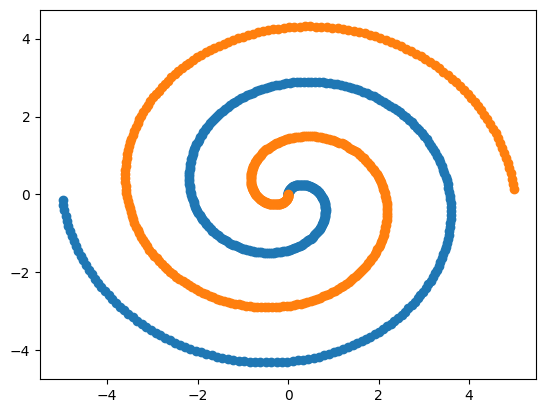

In [401]:
def genSpiral(delta_t, label):
    r = 5*torch.linspace(0., 1., N+1)[:N]
    t = 0.7*r*math.pi + delta_t
    x0 = r*torch.sin(t)
    x1 = r*torch.cos(t)
    y = label*torch.ones_like(x0)
    x = torch.stack((x0, x1), -1)
    sampled_noise = (NOISE/70.)*(2*torch.rand(N, 2) - 1.)
    x += sampled_noise
    return x, y

class SpiralDataset:
    def __init__(self):
        xp, yp = genSpiral(0, 1) # positive samples
        xn, yn = genSpiral(math.pi, -1) # negative samples
        self.X = torch.cat((xp, xn))
        self.Y = torch.cat((yp, yn))

spiral = SpiralDataset()
plot_data(spiral)

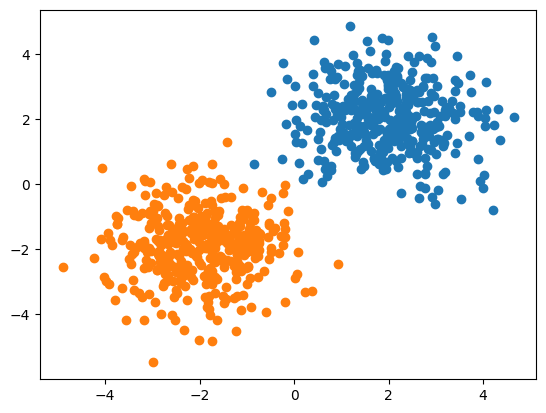

In [402]:
def genGauss(cx0, cx1, label):
    x = torch.randn(N, 2)
    x = torch.tensor([cx0, cx1]).T + x + x*(NOISE/25.)
    y = label*torch.ones(N)
    return x, y

class GaussDataset:
    def __init__(self):
        xp, yp = genGauss(2, 2, 1)
        xn, yn = genGauss(-2, -2, -1)
        self.X = torch.cat((xp, xn))
        self.Y = torch.cat((yp, yn))

gauss = GaussDataset()
plot_data(gauss)

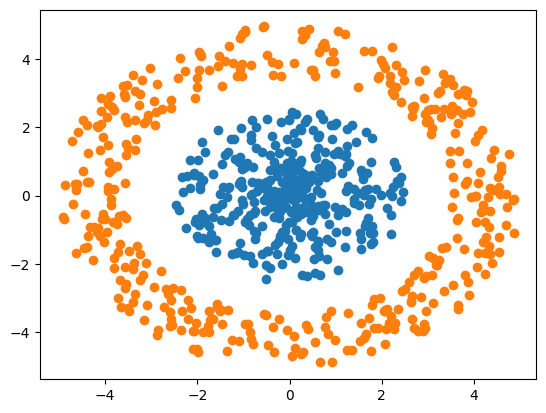

In [403]:
def genCircle(r_min, r_max, label):
    r = (r_max - r_min)*torch.rand(N) + r_min
    angle = 2*math.pi*torch.rand(N)
    x0 = r*torch.sin(angle)
    x1 = r*torch.cos(angle)
    x = torch.stack((x0, x1), -1)
    sampled_noise = (NOISE/35.)*(2*torch.rand(N, 2) - 1.)
    x += sampled_noise
    y = label*torch.ones_like(x0)
    return x, y

class CircleDataset:
    def __init__(self):
        xp, yp = genCircle(0, 2.5, 1) # positive samples
        xn, yn = genCircle(3.5, 5, -1) # negative samples
        self.X = torch.cat((xp, xn))
        self.Y = torch.cat((yp, yn))

circle = CircleDataset()
plot_data(circle)

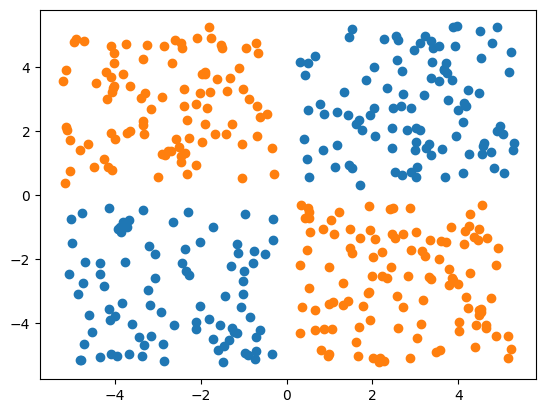

In [404]:
def genXOR():
    x = 10.*torch.rand(N, 2) - 5.
    y = torch.sign(x[:,0]*x[:,1])
    padding = 0.3
    x += torch.sign(x)*padding
    sampled_noise = (NOISE/25.)*(2*torch.rand(N, 2) - 1.)
    x += sampled_noise
    return x, y

class XORDataset:
    def __init__(self):
        self.X, self.Y = genXOR()

xor = XORDataset()
plot_data(xor)

##  Code

In [327]:
def train_test_split(dataset, test_size, square=False):
    num_samples = len(dataset.X)
    num_test_samples = int(test_size * num_samples)

    indices = torch.randperm(num_samples)

    test_indices = indices[:num_test_samples]
    train_indices = indices[num_test_samples:]

    X_train = dataset.X[train_indices]
    y_train = dataset.Y[train_indices]
    X_test  = dataset.X[test_indices]
    y_test  = dataset.Y[test_indices]

    if square:
        X_train = dataset_square(X_train)
        X_test = dataset_square(X_test)

    train_dataset = list(zip(X_train, y_train))
    test_dataset = list(zip(X_test, y_test))

    return train_dataset, test_dataset

In [328]:
def dataset_square(X):
  column1 = X[:, 0]
  column2 = X[:, 1]
  column3 = column1.pow(2)
  column4 = column2.pow(2)

  X = torch.stack((column1, column2, column3, column4), dim=1)

  return X

In [329]:
class Layer(nn.Module):
    def __init__(self, n_in, n_out):
        super(Layer, self).__init__()
        self.fc1 = nn.Linear(n_in, n_out)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.sigmoid(x)
        return x

In [330]:
class NeuralNetwork(nn.Module):
    def __init__(self, hidden_layers, n_neuron, entrys):
        super(NeuralNetwork, self).__init__()
        self.layers = []
        self.fc1 = nn.Linear(entrys, n_neuron[0])
        self.sigmoid = nn.Sigmoid()

        for n in range(hidden_layers-1):
            self.layers += [Layer(n_neuron[n], n_neuron[n+1])]

        self.network = nn.Sequential(*self.layers)
        self.output = nn.Linear(n_neuron[-1], 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.sigmoid(x)
        x = self.network(x)
        x = self.output(x)
        x = self.sigmoid(x)
        return x

In [331]:
class Learner:
    def __init__(self, hidden_layers, neuron_vector, entrys, lr):
        self.model = NeuralNetwork(hidden_layers, neuron_vector, entrys)
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr)

    def predict(self, x):
        return self.model(x)

    def update(self, loss):
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [332]:
class Evaluator:
    def __init__(self):
        self.loss_fn = nn.MSELoss()

    def get_loss(self, y, y_hat):
        y_hat = y_hat.squeeze(1)
        return self.loss_fn(y_hat, y)

In [333]:
class Trainer:
    def __init__(self, train_dataset, test_dataset, learner: Learner, evaluator: Evaluator, batch_size):
        self.train_dataset = train_dataset
        self.test_dataset = test_dataset
        self.learner = learner
        self.batch_size = batch_size
        self.evaluator = evaluator
        self.log = defaultdict(list)
        self.log['correct'].append(0)
        self.log['total'].append(0)

    def train(self):
        self.learner.model.train()
        dataloader = DataLoader(self.train_dataset, batch_size=self.batch_size)
        epoch_loss = 0
        num_batches = len(dataloader)

        for batch_idx, (X,y) in enumerate(dataloader):
            y_hat = self.learner.predict(X)
            loss = self.evaluator.get_loss(y,y_hat)
            epoch_loss += loss.item()
            self.learner.update(loss)

        #print(f"avarage train loss: {epoch_loss/num_batches}")
        self.log['train_loss'] += [epoch_loss / num_batches]

    def test(self):
        self.learner.model.eval()
        dataloader = DataLoader(self.test_dataset, batch_size=self.batch_size)
        epoch_loss, correct = 0 , 0
        num_batches = len(dataloader)

        with torch.no_grad():
            for X,y in dataloader:
                y_hat = self.learner.predict(X)
                loss = self.evaluator.get_loss(y,y_hat)
                epoch_loss += loss.item()
                for pred, answer in zip(torch.squeeze(y_hat).detach().numpy(), torch.squeeze(y).detach().numpy()):
                    if answer == -1 and pred < 0.5:
                        correct += 1
                    elif answer == 1 and pred >= 0.5:
                        correct += 1

            self.log['test_loss'] += [epoch_loss / num_batches]
            self.log['correct'] = correct
            self.log['total'] = len(dataloader.dataset)

    def run(self, n_epochs: int):
        for t in range(n_epochs):
            self.train()
            self.test()
            if (t+1) % 100 == 0:
                print(f"Epoch {t+1}\n------------")
                print(f"Train loss {self.log['train_loss'][-1]}\nTest loss {self.log['test_loss'][-1]}")
        print("Done!")

## Running

Dado que a inicialização dos pesos é a padrão do *PyTorch*, os resultados podém variar, recomenda-se algumas execuções para atingir melhores precisões no *Exclusive OR* e no *Spiral*.

* **Learner**
    * hidden_layers: quantidade de camadas intermediárias
    * neuron_vector: vetor contendo a quantidade de neurônios de cada camada intermediária
    * entrys: número de entradas da rete
    * lr: taxa de aprendizado
* **train_test_split**
    * dataset (circle, gauss, spiral, xor)
    * test_size: porcentagem dos dados separada para teste
    * square:
        * True: adiciona as entradas *x1²*, *x2²*
        * False: valor padrão, mantém apenas as entradas *x1*, *x2*
* **Trainer**:
    * train_dataset: dataset de treino
    * test_dataset: dataset de teste
    * batch_size: tamanho de cada batch

### Circle

In [415]:
evaluator = Evaluator()

In [416]:
learner = Learner(hidden_layers=2, neuron_vector=[4,2], entrys=4, lr=0.1)

In [417]:
train_dataset, test_dataset = train_test_split(circle, test_size=0.5, square=True)
trainer = Trainer(train_dataset, test_dataset, learner, evaluator, batch_size=10)

In [418]:
trainer.run(300)

Epoch 100
------------
Train loss 0.5238067384809255
Test loss 0.4988817095756531
Epoch 200
------------
Train loss 0.5156759060919285
Test loss 0.4906993040814996
Epoch 300
------------
Train loss 0.5142787091434002
Test loss 0.4892897387966514
Done!


Final train loss : 0.5143
Final test loss : 0.4893
[Total/Correct] : [400]/[400]
Precision : 100.0%


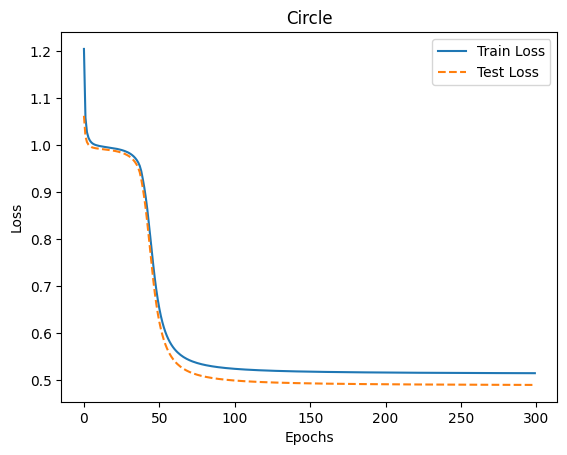

In [419]:
plt.plot(trainer.log['train_loss'], label='Train Loss')
plt.plot(trainer.log['test_loss'], '--', label='Test Loss')
plt.title('Circle')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
print(f"Final train loss : {trainer.log['train_loss'][-1]:.4}\nFinal test loss : {trainer.log['test_loss'][-1]:.4}")
print(f"[Total/Correct] : [{trainer.log['correct']}]/[{trainer.log['total']}]")
print(f"Precision : {trainer.log['correct']*100/trainer.log['total']}%")

### Exclusive OR

In [410]:
evaluator = Evaluator()

In [411]:
learner = Learner(hidden_layers=2, neuron_vector=[4,2], entrys=4, lr=0.1)

In [412]:
train_dataset, test_dataset = train_test_split(xor, test_size=0.5, square=True)
trainer = Trainer(train_dataset, test_dataset, learner, evaluator, batch_size=10)

In [413]:
trainer.run(500)

Epoch 100
------------
Train loss 0.9668974846601486
Test loss 0.9930222660303116
Epoch 200
------------
Train loss 0.645297521725297
Test loss 0.7285534486174583
Epoch 300
------------
Train loss 0.5214099388569593
Test loss 0.5919614717364311
Epoch 400
------------
Train loss 0.49908600210910664
Test loss 0.5798377484083176
Epoch 500
------------
Train loss 0.4954001014470123
Test loss 0.5764981478452682
Done!


Final train loss : 0.4954
Final test loss : 0.5765
[Total/Correct] : [200]/[200]
Precision : 100.0%


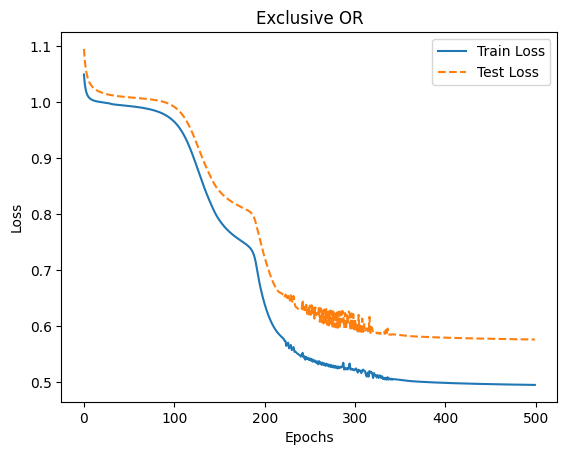

In [414]:
plt.plot(trainer.log['train_loss'], label='Train Loss')
plt.plot(trainer.log['test_loss'], '--', label='Test Loss')
plt.title('Exclusive OR')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
print(f"Final train loss : {trainer.log['train_loss'][-1]:.4}\nFinal test loss : {trainer.log['test_loss'][-1]:.4}")
print(f"[Total/Correct] : [{trainer.log['correct']}]/[{trainer.log['total']}]")
print(f"Precision : {trainer.log['correct']*100/trainer.log['total']}%")

### Gaussian

In [420]:
evaluator = Evaluator()

In [421]:
learner = Learner(hidden_layers=1, neuron_vector=[1], entrys=2, lr=0.1)

In [422]:
train_dataset, test_dataset = train_test_split(gauss, test_size=0.5)
trainer = Trainer(train_dataset, test_dataset, learner, evaluator, batch_size=10)

In [423]:
trainer.run(100)

Epoch 100
------------
Train loss 0.5432679064571857
Test loss 0.477043304219842
Done!


Final train loss : 0.5433
Final test loss : 0.477
[Total/Correct] : [398]/[400]
Precision : 99.5%


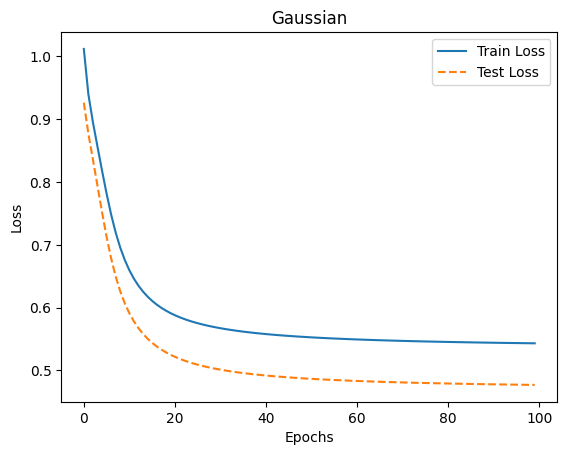

In [424]:
plt.plot(trainer.log['train_loss'], label='Train Loss')
plt.plot(trainer.log['test_loss'], '--', label='Test Loss')
plt.title('Gaussian')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
print(f"Final train loss : {trainer.log['train_loss'][-1]:.4}\nFinal test loss : {trainer.log['test_loss'][-1]:.4}")
print(f"[Total/Correct] : [{trainer.log['correct']}]/[{trainer.log['total']}]")
print(f"Precision : {trainer.log['correct']*100/trainer.log['total']}%")

### Spiral

In [430]:
evaluator = Evaluator()

In [431]:
learner = Learner(hidden_layers=2, neuron_vector=[8,2], entrys=4, lr=0.1)

In [432]:
train_dataset, test_dataset = train_test_split(spiral, test_size=0.5, square=True)
trainer = Trainer(train_dataset, test_dataset, learner, evaluator, batch_size=10)

In [433]:
trainer.run(1000)

Epoch 100
------------
Train loss 0.993438272178173
Test loss 1.0140300005674363
Epoch 200
------------
Train loss 0.9588116362690926
Test loss 1.0148460268974304
Epoch 300
------------
Train loss 0.9378268763422966
Test loss 1.0127410039305687
Epoch 400
------------
Train loss 0.8721659168601036
Test loss 0.9436213165521622
Epoch 500
------------
Train loss 0.7261243730783462
Test loss 0.7794047385454178
Epoch 600
------------
Train loss 0.6286559797823429
Test loss 0.6824641041457653
Epoch 700
------------
Train loss 0.5419022429734468
Test loss 0.6011398017406464
Epoch 800
------------
Train loss 0.5204734753817319
Test loss 0.58407918587327
Epoch 900
------------
Train loss 0.4775655010715127
Test loss 0.5452671401202679
Epoch 1000
------------
Train loss 0.4741242043673992
Test loss 0.5424415767192841
Done!


Final train loss : 0.4741
Final test loss : 0.5424
[Total/Correct] : [398]/[400]
Precision : 99.5%


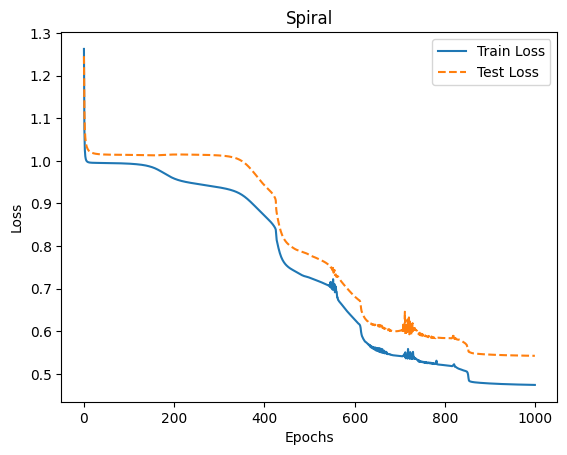

In [434]:
plt.plot(trainer.log['train_loss'], label='Train Loss')
plt.plot(trainer.log['test_loss'], '--', label='Test Loss')
plt.title('Spiral')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
print(f"Final train loss : {trainer.log['train_loss'][-1]:.4}\nFinal test loss : {trainer.log['test_loss'][-1]:.4}")
print(f"[Total/Correct] : [{trainer.log['correct']}]/[{trainer.log['total']}]")
print(f"Precision : {trainer.log['correct']*100/trainer.log['total']}%")